In [1]:
#Script to evaluate the determinants of patent citation 
#Renato Kogeyama

# August 19, 2020
# Updated all files to latest data available in PatentsView (Jun/2020)
# Excluded self citations from the dataset

# July 13, 2020
# I am changing the script to test Nemet and Johnson 2012, but with centrality measures as DV

# Apr 27, 2020
# Separe most central patents, classify them as disruptive and calculate dvs from extant literature

# Mar 16, 2020
# Introducing centrality measures as dv

# Feb 04, 2020
# to set labels in heatmap keyword:xticklabels
# for ex.
# sns.heatmap(globalWarming_df, xticklabels = np.arange(0,15))
# to be implemented later
# another alternative is to substitute the values in the dataset and convert columns to categories
# to understand the impact, i should run some test
# however i am focusing now in calculate Corredoira's 2015 and Nemet & Johnson 2012

# Feb 03, 2020
# version backed up as _old

# Feb 02, 2020
# the best way to deal with the classification names is to use a dictionary
# this avoid charging memory with the strings
# However, WIPO is organized differently than the other systems
# I'll update the wipo code to uniformize the behavior in this script
# I am creating a code that reflects the first level of classification 

# Feb 01, 2020
# Introduction of categorical graphs: barplot and heatmap
# heatmap is not the real deal, its a simplification
# the real deal would be the correlation table - there is a suggestion based on cramer, 
    # but implementation was not ready
# graphs exported and google docs updated
# next step: update cit_tree to reflect Corredoira's 205 Influence measure
# plot a network graph: https://plot.ly/python/network-graphs/
# reproduce 2012 Nemet and Johnson with other class systems
# correct bias in generality and originality (multiply for N/N-1)

# Jan 21, 2020
# Classifications added
# Code reorganized - much faster now
# Still missing the update of applications to the grant number
# I should provide now descriptive statistics on all variables

# Jan 21, 2020
# The current data does not have Class
# I should go back and get this info - but there are too many scripts now and
#   I should reorganize them before moving forward
# I should also include the patent publication date - to control for the policy changes
# In the citation file, I should change application number for grant when possible 
#   This will improve realiability of all measures related to citation
# Introduce classifications

# Jan 18, 2020
# Variables calculated
# Generality, average delay, forward and backward citations, cumulative citation (cit_tree)
# Still missing originality
# the file with variables that are used in this script should get a name independent from the date


#Miami, December 24th, 2019
# Prof. Rafael Corredoira suggested:
# - Inclusion of a tree of citations
#   To track back the source of citations. This is information is not given by direct count of citations.
# - Consider policy changes in the way patents are cited
#   Policy changes in 2000 changed the time frame of citation, and 2010 partially moved citation to applications
# - Track classification changes 
#   The original classification system in USPTO changed from a technical based to a market based classification system
#   See if there is an impact
# - Consider a text analysis of the claims
#   Classification is based on the claims but it is not clear how many claims are related to each classification category
# - Include moderation effect from classification
#   Citations patterns may change across industries, so some effects may disappear if industry is not accounted for.

# In summary, his ideas help increase structure of the current work


#Syracuse, December 3rd, 2019

#The original script is getting too complex
#There was many tentative scripts to play with data
#Here I am writing a script to show the relevance of variables to patent citation

#11-12-2019
#Introducing normalization

#10-11-2019
#I introduced log backward citation, what corrects for very dispersed results
#but the major problem is that few patents receive citations
#bring back binary output

#10-10-2019
#Added graphics and new distributions

#10-03-2019
#I rewrote the citation data to clean the strings

#09-15-2019
#O naive bayes tem algum problema com distribuicoes desbalanceadas
#o scikit learn tem um modulo que corrige count distributions com muitos zeros, o complementNB
#porem este nao esta disponivel na atual versao disponibilizada no HPC da FIU

#09-10-2019
#o trabalho pede uma abordagem mais sistematica e cuidadosa
#estou agrupando o codigo antigo comentado e vou comecar um novo codigo

#09-27-2019
#I am renaming citation as forward citation and backward citation

#09-17-2018

#Alto uso de memoria - rodar no Amazon AWS 



In [2]:
import pandas as pd
import numpy as np
import IPython.display as display
import seaborn as sns
          
import itertools

from sklearn import preprocessing
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import naive_bayes
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression

import scipy.stats as ss
import datetime
import matplotlib.pyplot as plt

from math import sqrt

import sys
sys.path.append('/home/rkogeyam/scripts/')
sys.path.append('scripts/')

from determinants_scripts import classes

from plotbar import plotbar
from plot_heat import heatmap


from best_num_attr import best_num_attr
from xattrSelect import xattrSelect
from sampler import sampler
from normalize import normalize
from nbayes import nbayes

import gzip
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
import math

In [3]:
latex='data/results.tex'
# dataset='data/dataset.csv'
dataset=gzip.open('data/dataset.csv.gz', 'rt')

In [4]:
%matplotlib inline
sns.set()
sns.set_palette(sns.cubehelix_palette(8))
# pd.options.display.float_format = '{:,.2f}'.format

In [5]:
dtypes={'id':object,'type':object, 'kind':object, 'num_claims':float, 'cit_received':float, 'cit_made':float,
       'cit_received_delay':float, 'cit_made_delay':float, 'parent_citation':float,
       'originality':float, 'generality':float, 'wipo_sector_id':object,'wipo_far_ext':float, 'wipo_ext':float,  'pagerank':float}

In [6]:
# only main classes (exclude uspc)

usecols=['id', 'date', 'num_claims', 'cit_received', 'cit_made',
         'cit_received_delay', 'cit_made_delay',
         'originality', 'generality', 'wipo_sector_id', 'wipo_far_ext', 'wipo_ext', 'pagerank']

In [7]:
# only WIPO class system, exclude type and kind

# usecols=['id', 'date', 'num_claims', 'cit_received', 'cit_made',
#         'cit_received_delay', 'cit_made_delay', 'parent_citation',
#         'originality', 'generality', 'wipo_sector_id', 'eigen', 'pagerank', 'katz']

In [8]:
df=pd.read_csv(dataset, usecols=usecols, dtype=dtypes, parse_dates=['date'], index_col='id')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9570679 entries, 0000000 to re25727
Data columns (total 12 columns):
date                  datetime64[ns]
num_claims            float64
cit_received          float64
cit_made              float64
cit_received_delay    float64
cit_made_delay        float64
originality           float64
generality            float64
wipo_sector_id        object
wipo_far_ext          float64
wipo_ext              float64
pagerank              float64
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 949.2+ MB


In [ ]:
df[(df['cit_received']>0) & (df['pagerank']>0)] #check if a patent without citations has centrality different from 0

In [9]:
df=df[df['cit_received']>0] #patents without citations introduce noise
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7632681 entries, 0000000 to re25727
Data columns (total 12 columns):
date                  datetime64[ns]
num_claims            float64
cit_received          float64
cit_made              float64
cit_received_delay    float64
cit_made_delay        float64
originality           float64
generality            float64
wipo_sector_id        object
wipo_far_ext          float64
wipo_ext              float64
pagerank              float64
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 757.0+ MB


In [10]:
df['year']=df.date.dt.year
# df['year']=df.date.dt.year.astype(str)
df['decade']=df.date.dt.year//10*10
df['decade'] =df['decade'].apply(lambda x: int(x) if str(x) != 'nan' else np.nan)
decades=list(df.decade.unique())
decades = [int(x) for x in decades if str(x) != 'nan']

In [11]:
obj_cols=list(df.select_dtypes(include=[object]).columns.values)
obj_cols

['wipo_sector_id']

In [12]:
num_cols=list(df.select_dtypes(include=[np.number]).columns.values)
num_cols

['num_claims',
 'cit_received',
 'cit_made',
 'cit_received_delay',
 'cit_made_delay',
 'originality',
 'generality',
 'wipo_far_ext',
 'wipo_ext',
 'pagerank',
 'year']

## Data Analysis

### Descriptive 

In [13]:
descriptive=df.describe(include=[np.number]).loc[['count','mean','std','min','max']].append(df[num_cols].isnull().sum().rename('isnull'))

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [14]:
output=[]
output.append(descriptive.apply(lambda x: x.apply('{:,.2f}'.format)).transpose().to_latex())
output.append("\\newpage\n")

In [15]:
# df.describe(include=[np.object])#.append(df[np.object].isnull().sum().rename('isnull')).transpose()

,wipo_sector_id
count,4819737
unique,5
top,1
freq,1701497


### Barplots and Heatmaps

In [16]:
# barplot
# as of 02.03.20, working

for i in obj_cols:
    plotbar(i, df, classes)

# barplot with decades
for i in obj_cols:
    plotbar(i, df, classes,decade=True)

# barplot with decades and inverted axis
for i in obj_cols:
    plotbar(i, df, classes,decade=True, decade_x=True)

# heatmaps all periods
for double in list(itertools.combinations(obj_cols, 2)):
    heatmap(df[double[0]], df[double[1]]) 

# print heatmaps per decade
for decade in decades:
    df_dec=df[df['decade']==decade]
    for double in list(itertools.combinations(obj_cols, 2)):
        heatmap(df_dec[double[0]], df_dec[double[1]], decade) 


### Histograms

In [17]:
#histograms
#could improve cutting off outliers
for variable in num_cols:
    ax=df[variable].hist()
    ax.set_title('Histogram '+ variable.title()+'\n')
    plt.show()

### Trends and Boxplots

In [18]:
#iterate over numerical variables

num_cols.remove('decade')
# num_cols.remove('year')

In [19]:
# for variable in num_cols:
    
#     title=variable.replace('_', ' ')
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

#     axes[0] = df.groupby('year').mean().plot(y=variable, ax=axes[0])
#     evl_title='Evolution of '+ title +'\n'
#     axes[0].set_title(evl_title)
#     axes[0].set_ylim(bottom=0)
    
#     axes[1] = sns.boxplot(x='decade', y=variable, data=df)

#     box_title='Dispersion of '+ title +'\n'
#     axes[1].set_title(box_title)
#     axes[1].set_ylim(bottom=0)
#     axes[1].set_ylabel("")
    
#     filename='./img/evol_dispersion_'+variable.lower()+'.png'  
#     plt.savefig(filename) 
#     plt.show()


In [20]:
# the generality data on the 2010's is too concentrated around 0
# to check, I draw this hist to understand what is happening
# it could be an effect of truncation - generality increases with forward citation

# df[df['decade']==2010]['generality'].hist()

### Models

In [22]:
# normalization
df=normalize(df.dropna())

Total number of observations and attributes
(3891146, 13)
Number of numerical attributes: 11
Number of non-numerical attributes: 11


/home/rkogeyam/scripts/normalize.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[num_cols]=min_max_scaler.fit_transform(df[num_cols])
/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3891146 entries, 3931349 to 9854083
Data columns (total 13 columns):
date                  datetime64[ns]
num_claims            float64
cit_received          float64
cit_made              float64
cit_received_delay    float64
cit_made_delay        float64
originality           float64
generality            float64
wipo_sector_id        object
wipo_far_ext          float64
wipo_ext              float64
pagerank              float64
year                  float64
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 415.6+ MB


In [24]:
df.head()

,date,num_claims,cit_received,cit_made,cit_received_delay,cit_made_delay,originality,generality,wipo_sector_id,wipo_far_ext,wipo_ext,pagerank,year
id,,,,,,,,,,,,,
3931349,1976-01-06,0.009029,0.022682,0.001033,0.353835,0.641222,0.0,0.000000,0,0.000000,0.022581,0.011216,0.0
3935991,1976-02-03,0.002257,0.004736,0.001205,0.270670,0.642102,0.0,0.138408,3,0.000326,0.000323,0.001409,0.0
3943789,1976-03-16,0.005643,0.001496,0.001205,0.316234,0.683412,0.0,0.000000,3,0.000000,0.002258,0.000505,0.0
3944004,1976-03-16,0.012415,0.001246,0.001377,0.277968,0.639338,0.0,0.625000,2,0.000651,0.000645,0.000662,0.0
3945191,1976-03-23,0.003386,0.004736,0.000688,0.131093,0.630650,0.0,0.000000,2,0.000000,0.000000,0.010436,0.0


In [25]:
# #maybe nb fit does not accept nomalized data, so i using data without normalize
# #but in that case, i have to transform the categorical variables

# obj_cols=list(df.select_dtypes(include=[object]).columns.values)

# for col in obj_cols:
#     df[col] = df[col].astype('category')

# df=pd.get_dummies(df, columns=obj_cols, prefix=obj_cols)

In [26]:
# List of IVs
chosenColumns=df.columns.values.tolist()
len(chosenColumns)

13

In [27]:
chosenColumns.remove('pagerank') #dv
chosenColumns.remove('date') #similar to year
chosenColumns.remove('wipo_sector_id') #iterate over patent class
len(chosenColumns)

10

In [28]:
wipo_sectors=df.wipo_sector_id.unique() #list of wipo sectors

In [29]:
df['pagerank'].nlargest()

id
4558413    1.000000
4395486    0.825510
4683195    0.787953
4298685    0.742378
5572643    0.561747
Name: pagerank, dtype: float64

In [30]:
max_pagerank=df['pagerank'].max() #variable used in the transformation
max_pagerank

0.99999999999999989

In [31]:
#transform DV first by inverting (max_pagerank-1) and then applying log (see Andy Field)
df['t_pagerank']=df['pagerank'].apply(lambda x: math.log(max_pagerank+1-x))

In [32]:
num_cols=list(df.select_dtypes(include=[np.number]).columns.values)
# num_cols

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


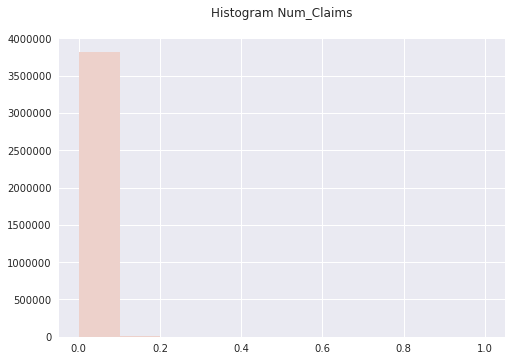

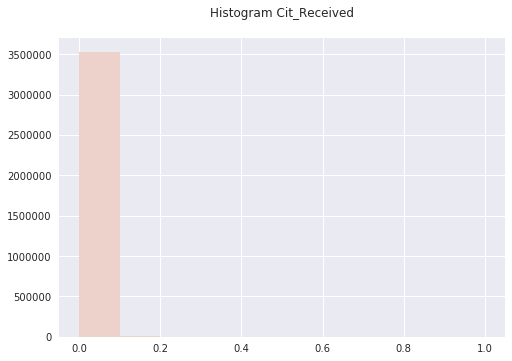

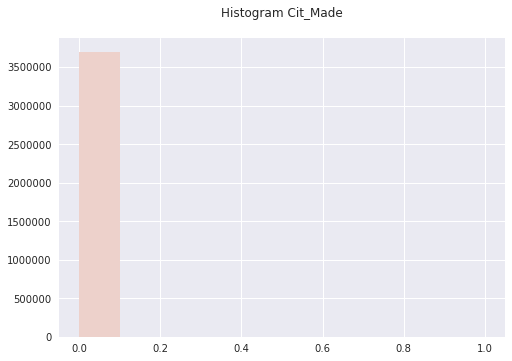

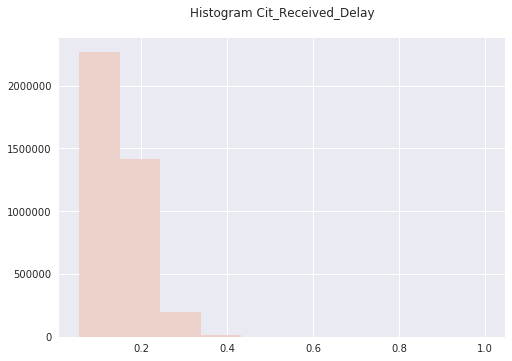

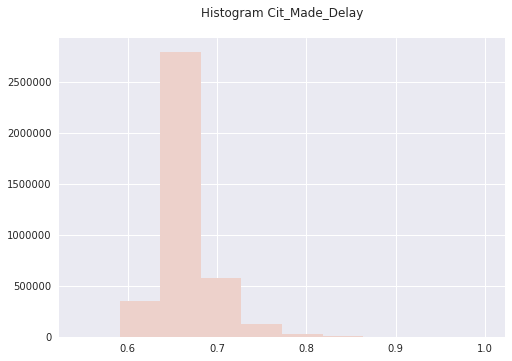

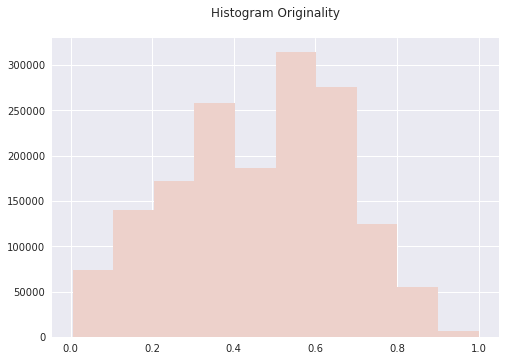

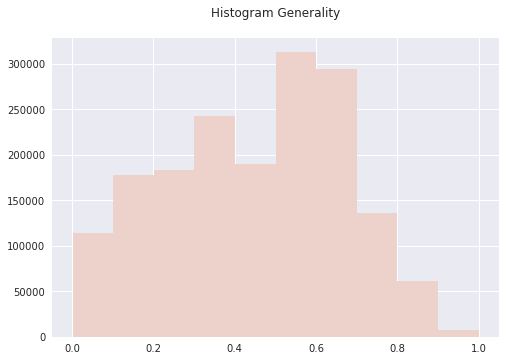

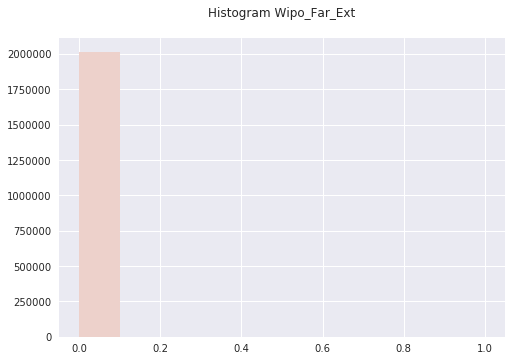

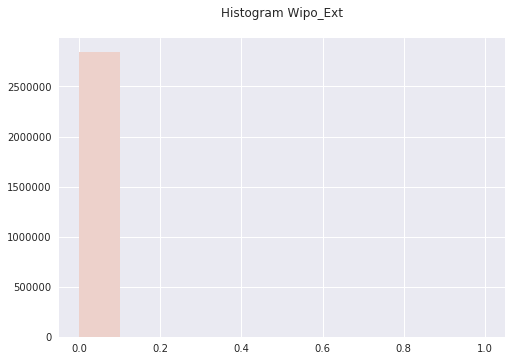

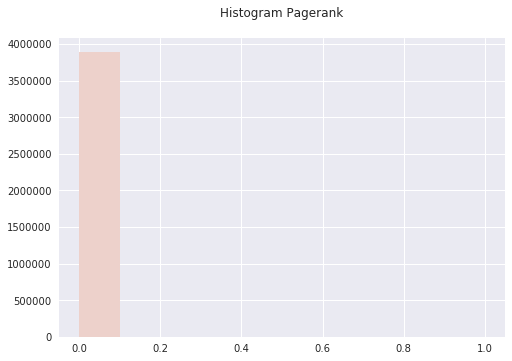

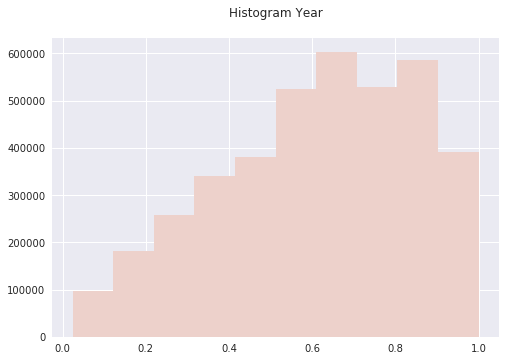

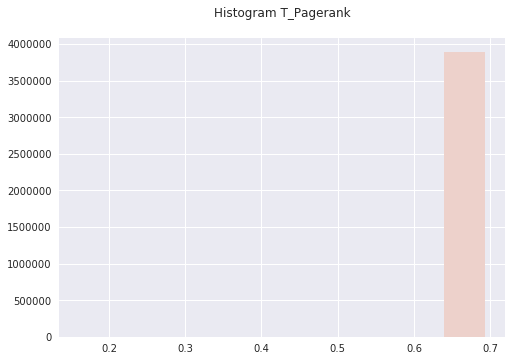

In [33]:
# histograms
for variable in num_cols:
    ax=df[df[variable]>df[variable].min()][variable].hist()
    ax.set_title('Histogram '+ variable.title()+'\n')
    plt.show()

In [34]:
#function to write results to a latex file 
def export_table(content, name):
    basename='output/'+ name
    i=1
    while os.path.exists(basename+"_"+"{:03d}".format(i)+'.out'):
        i += 1
    with open(basename+"_"+"{:03d}".format(i)+'.out','w') as fh:
        for element in content:
            fh.write( element )
 

In [35]:
wipo_sector_title={
    '0':"Chemistry",
    '1':"Electrical Eng",
    '2':"Instruments",
    '3':"Mechanical Eng",
    '4':"Other fields",
    '5':"Plant"
    }

In [ ]:
formula='t_pagerank ~ num_claims + cit_received + cit_made + cit_received_delay + cit_made_delay + originality + generality + wipo_far_ext + wipo_ext + year'

for wipo_sector in wipo_sectors:
#     print(wipo_sector_title[wipo_sector])
#     print(df[df.wipo_sector_id==wipo_sector].head())
#     print("\n")
    
#     myX = df[df.wipo_sector_id==wipo_sector].as_matrix(columns=chosenColumns)
#     myY = df[df.wipo_sector_id==wipo_sector].as_matrix(columns=['t-pagerank'])

    data=df[df.wipo_sector_id==wipo_sector]
#     x = sm.add_constant(myX)
#     model = sm.OLS(myY, x)
    model = smf.ols(formula, data=data) #smf permite a construcao de formulas estilo R
                                        #o uso de smf permite que os nomes das variaveis aparecam 
                                        #automaticamente no plot_partregress_grid
    results = model.fit()    
    output.append("WIPO: " + wipo_sector_title[wipo_sector])
    output.append(results.summary(title="OLS of WIPO: " + wipo_sector_title[wipo_sector]).as_latex())
    output.append("\\newpage\n")
    for element in chosenColumns:
        fig = sm.graphics.plot_regress_exog(results, element)
        fig.tight_layout(pad=1.0)

#     print('\n')
#     print(wipo_sector_title[wipo_sector].title())
#     print('\n')
#     fig = plt.figure(figsize=(12, 20))
#     fig = sm.graphics.plot_partregress_grid(results, fig=fig)
#     fig.tight_layout(pad=1.0)
#     plt.savefig('img/partial_reg_plot'+wipo_sector_title[wipo_sector].replace(" ", "_")+'.png')
#     results.summary()



Chemistry




/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




Mechanical Eng




Instruments




Electrical Eng




Other Fields




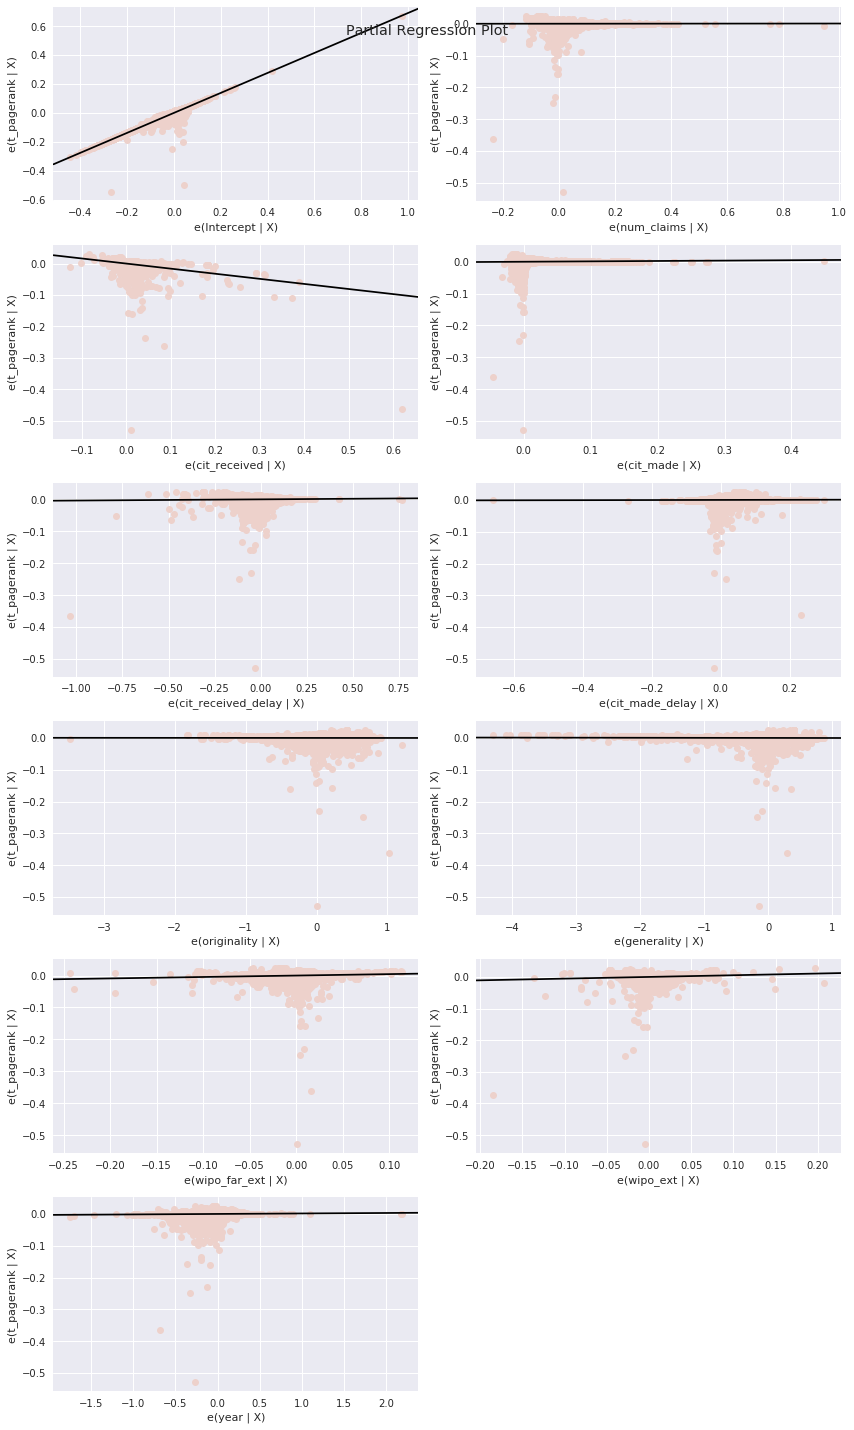

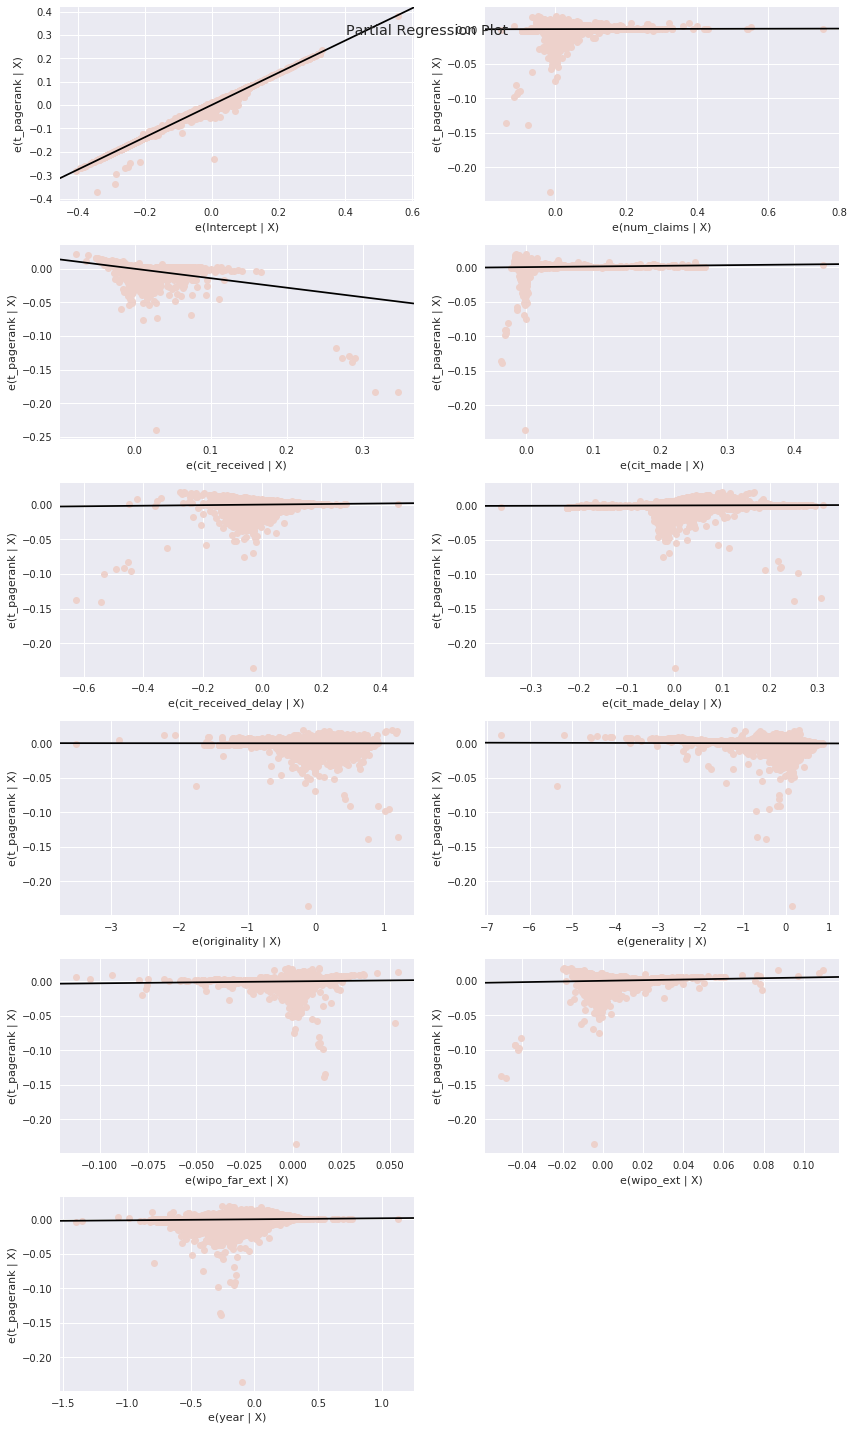

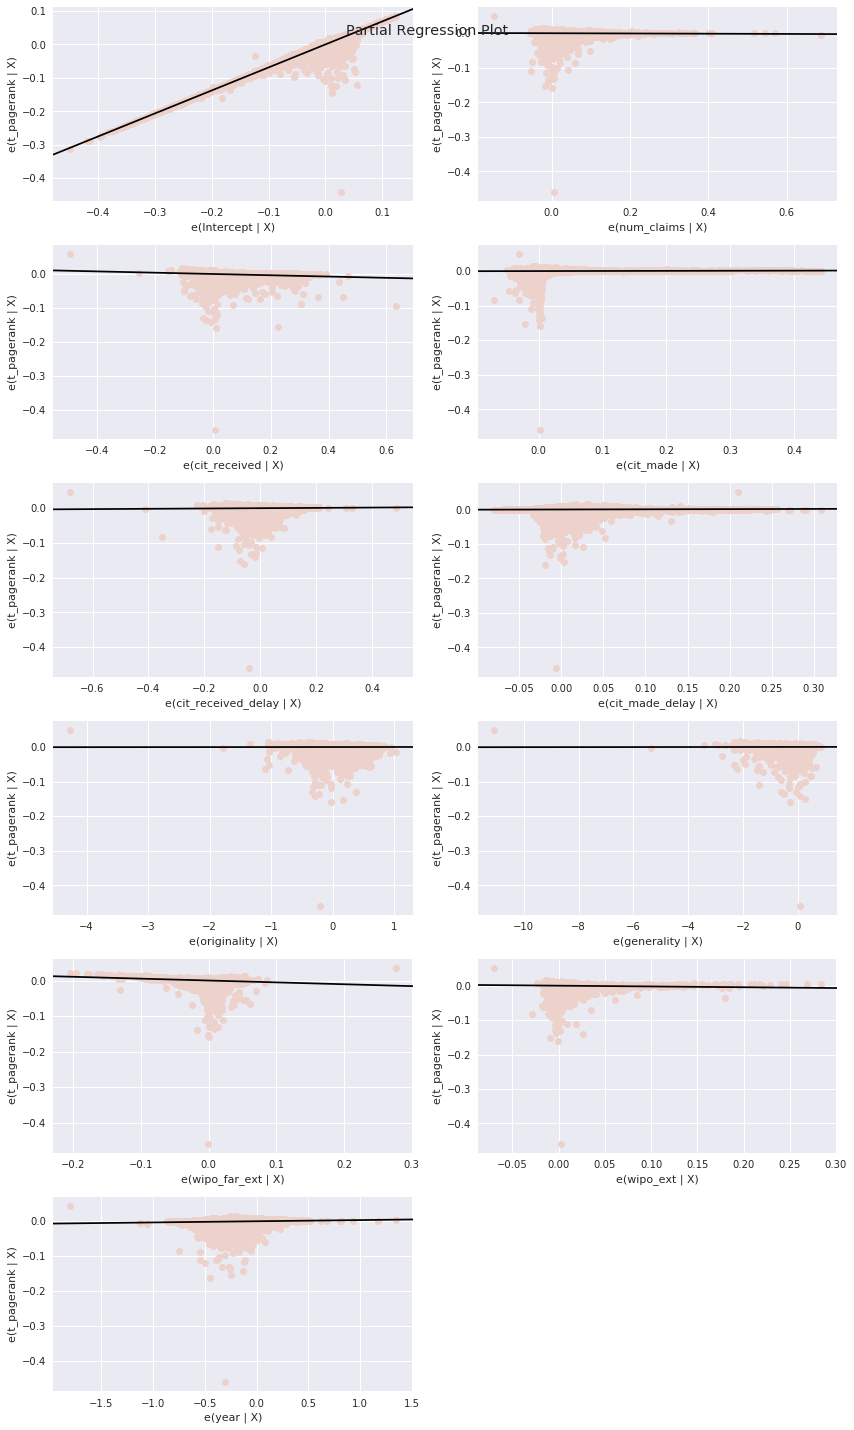

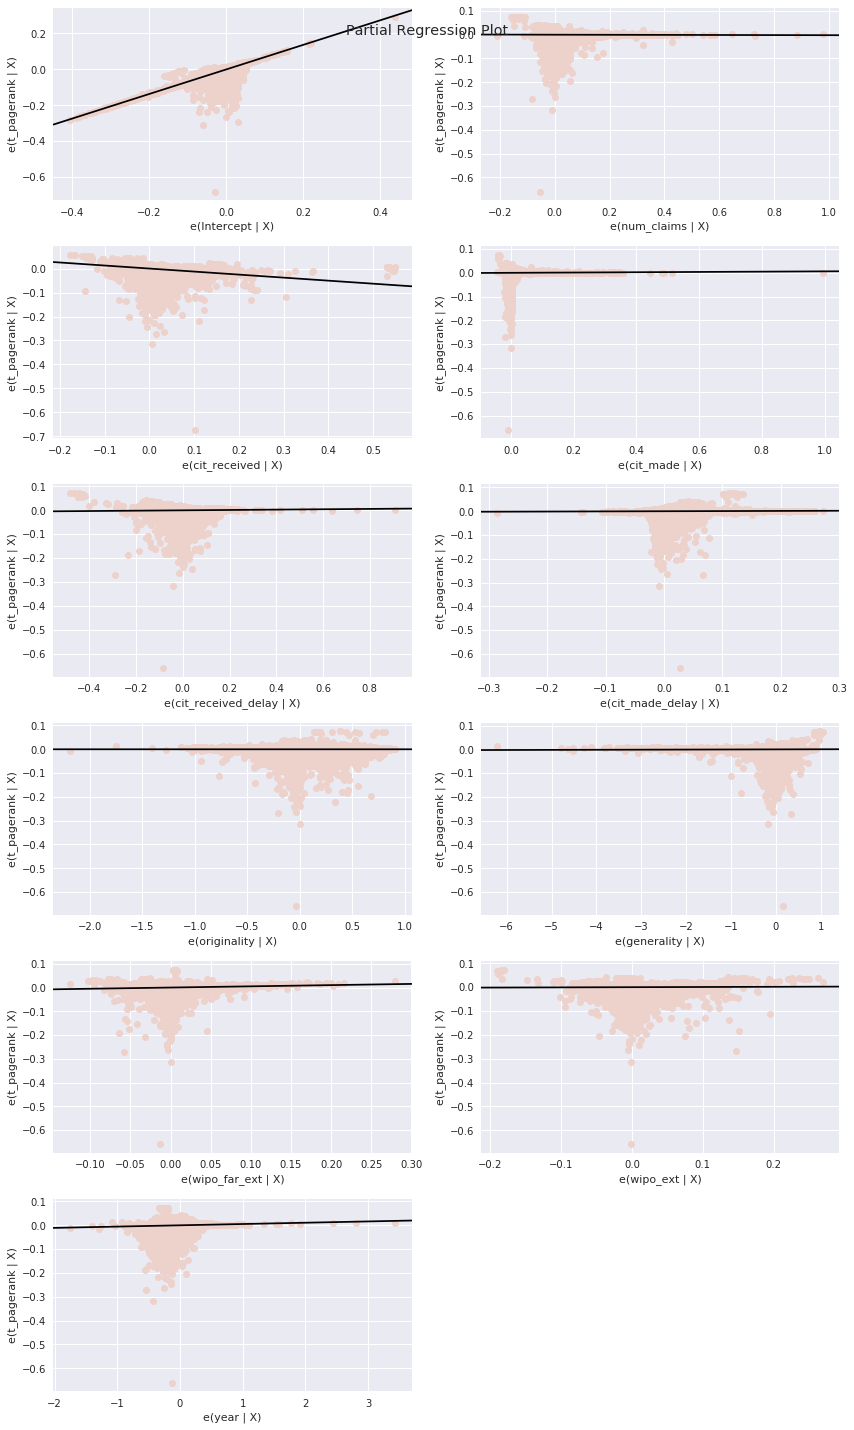

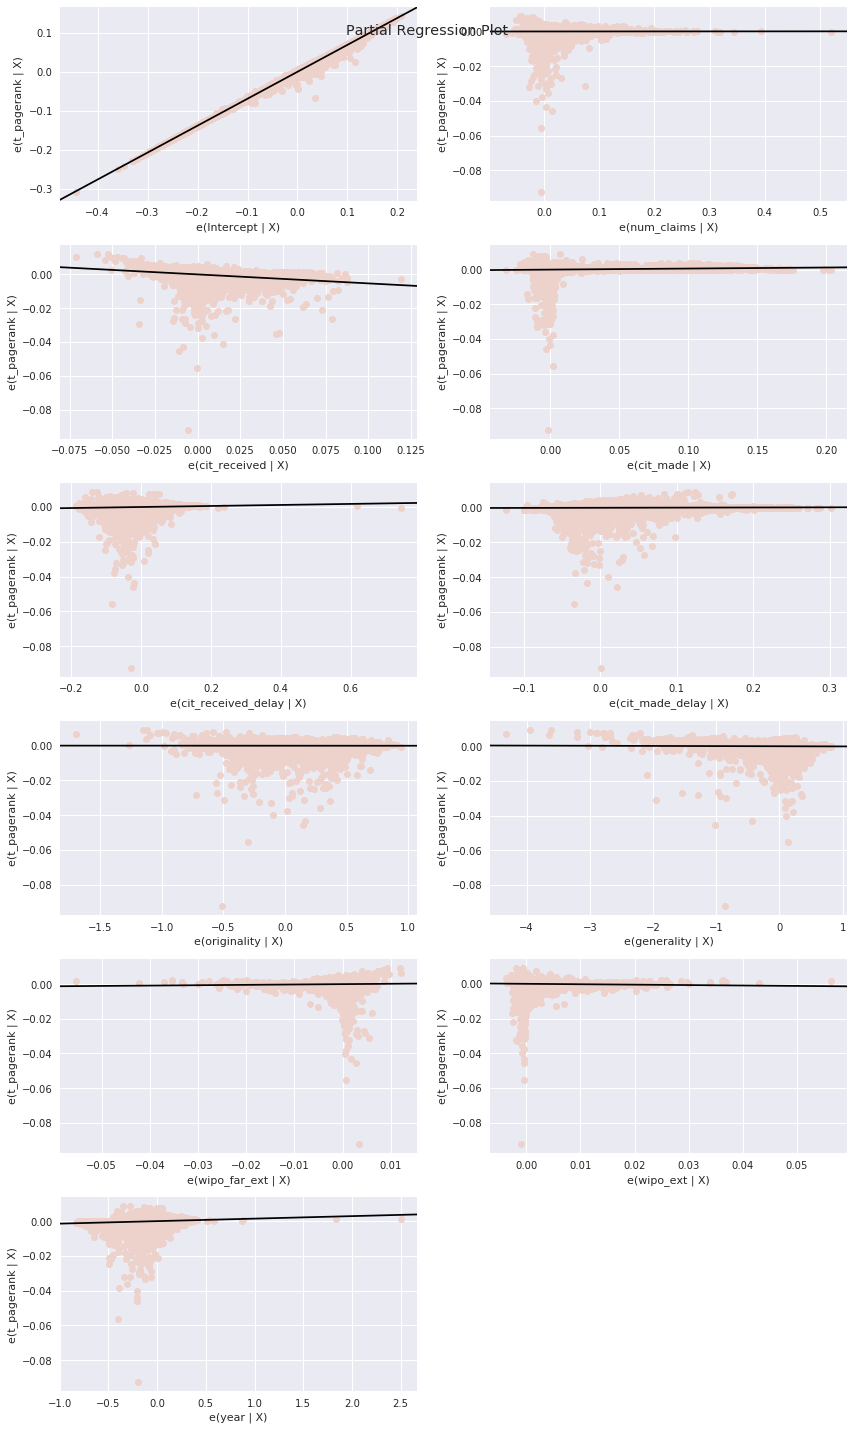

In [36]:
export_table(output, "output_by_wipo")

### DV: Parent citation (rename the variable)

In [37]:
# myX = df.as_matrix(columns=chosenColumns)

# myY = df.as_matrix(columns=['parent_citation'])

# xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3) 
# testSize = yTest.shape[0]
# trainSize = yTrain.shape[0]
# namesList, errorList = best_num_attr(myX, xTrain, xTest, yTrain, yTest, chosenColumns, regtype='linear')

### DV: pagerank (centrality)

In [38]:
# myX = df.as_matrix(columns=chosenColumns)
# myY = df.as_matrix(columns=['pagerank'])

# xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3) 
# testSize = yTest.shape[0]
# trainSize = yTrain.shape[0]

In [39]:
# namesList, errorList = best_num_attr(myX, xTrain, xTest, yTrain, yTest, chosenColumns, regtype='linear')

### DV: katz (centrality)

In [40]:
# myX = df.as_matrix(columns=chosenColumns)
# myY = df.as_matrix(columns=['katz'])

# xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3) 
# testSize = yTest.shape[0]
# trainSize = yTrain.shape[0]

In [41]:
# namesList, errorList = best_num_attr(myX, xTrain, xTest, yTrain, yTest, chosenColumns, regtype='linear')

### DV: eigen (centrality)

In [42]:
# myX = df.as_matrix(columns=chosenColumns)
# myY = df.as_matrix(columns=['eigen'])

# xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3) 
# testSize = yTest.shape[0]
# trainSize = yTrain.shape[0]

In [43]:
# namesList, errorList = best_num_attr(myX, xTrain, xTest, yTrain, yTest, chosenColumns, regtype='linear')

In [44]:
# This selector does not work because almost every attribute is p-value significant

# selector = SelectKBest(f_classif, k=4) #initialize 
# selector.fit(myX, myY) #fit
# scores = -np.log10(selector.pvalues_) #transform pvalues (why?)
# scores /= scores.max() #normalize 
# plt.bar(myX - .45, scores, width=.2,
#         label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
#         edgecolor='black')

In [45]:
# nbayes(xTrain, yTrain, xTest, yTest)

In [46]:
# df.dropna()

In [47]:
# #Let's do something else
# #Change the DV 

# myX = df.as_matrix(columns=chosenColumns)
# myY = df.as_matrix(columns=['parent_back_citation'])

# xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3) 

In [48]:
# nbayes(xTrain, yTrain, xTest, yTest)

In [49]:
# df.parent_back_citation.boxplot()

In [50]:
#and graphs of back citation in time

In [51]:
# for i in classifications:
#     rank=df.groupby(i).count().iloc[:,2].sort_values(ascending=False).reset_index().set_index(i)
#     description=df_class[df_class['class']==i].set_index('id')
#     display(rank.join(description))

In [52]:
# for i in obj_cols:
#     if i.isin(classifications):
#         df.join(df.groupby(i).count().iloc[:,2].sort_values(ascending=False)
# #     display.display(df.pivot_table(values=df.reset_index().id, index=i, columns='decade', aggfunc='count', fill_value=0, margins=False, dropna=True))
#     print(i)
#     display.display(df.groupby(i).count().iloc[:,2].sort_values(ascending=False))

In [53]:
# def cramers_v(x, y):
#     confusion_matrix = pd.crosstab(x,y)
#     chi2 = ss.chi2_contingency(confusion_matrix)[0]
#     n = confusion_matrix.sum().sum()
#     phi2 = chi2/n
#     r,k = confusion_matrix.shape
#     phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
#     rcorr = r-((r-1)**2)/(n-1)
#     kcorr = k-((k-1)**2)/(n-1)
#     return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [54]:
# all variables
# dtypes={'id':object, 'type':object, 'kind':object, 'num_claims':float, 'cit_received':float, 'cit_made':float,
#        'cit_received_delay':float, 'cit_made_delay':float, 'parent_citation':float,
#        'originality':float, 'generality':float, 'wipo_field_id':object, 'ipcr_section':object,
#        'cpc_section_id':object,'nber_category_id':object,'uspc_mainclass_id':object}